In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [3]:
input_location = 'KTH-alloc-only-filter'
files_prefix = ''
# schedule_names = ['filler', 'backfill-1', 'backfill-sjf-1', 'maxutil-10-1', 'maxutil-15-1', 'maxutil-20-1', 'maxutil-comp-5-5-1', 'plan-1']
schedule_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-opt-10-1', 'window-10-10-1', 'plan-opt-square-0', 'plan-opt-cube-0']
new_names = ['backfill-1', 'backfill-sjf-1', 'maxutil-1.0-1', 'window-1', 'plan-square-0', 'plan-cube-0']

In [4]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-alloc-only-filter/backfill-1_schedule.csv', '../output/KTH-alloc-only-filter/backfill-sjf-1_schedule.csv', '../output/KTH-alloc-only-filter/fcfs_schedule.csv', '../output/KTH-alloc-only-filter/filler_schedule.csv', '../output/KTH-alloc-only-filter/maxutil-opt-10-1_schedule.csv', '../output/KTH-alloc-only-filter/no-future-1_schedule.csv', '../output/KTH-alloc-only-filter/plan-opt-cube-0_schedule.csv', '../output/KTH-alloc-only-filter/plan-opt-square-0_schedule.csv', '../output/KTH-alloc-only-filter/window-10-10-1_schedule.csv']
['../output/KTH-alloc-only-filter/backfill-1_jobs.csv', '../output/KTH-alloc-only-filter/backfill-sjf-1_jobs.csv', '../output/KTH-alloc-only-filter/fcfs_jobs.csv', '../output/KTH-alloc-only-filter/filler_jobs.csv', '../output/KTH-alloc-only-filter/maxutil-opt-10-1_jobs.csv', '../output/KTH-alloc-only-filter/no-future-1_jobs.csv', '../output/KTH-alloc-only-filter/plan-opt-cube-0_jobs.csv', '../output/KTH-alloc-only-filter/plan-opt-square-0_jobs.csv

In [5]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 backfill-1
 backfill-sjf-1
 maxutil-opt-10-1
 plan-opt-cube-0
 plan-opt-square-0
 window-10-10-1


In [6]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 backfill-sjf-1
 maxutil-opt-10-1
 plan-opt-cube-0
 plan-opt-square-0
 window-10-10-1


In [7]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [8]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [17]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [13]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [19]:
metrics.T

,backfill-1,backfill-sjf-1,maxutil-opt-10-1,window-10-10-1,plan-opt-square-0,plan-opt-cube-0
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0
makespan,2.87948e+07,2.8794e+07,2.87845e+07,2.87738e+07,2.87712e+07,2.87735e+07
max_slowdown,197917,287203,250556,280246,247174,140606
max_turnaround_time,622412,815654,667983,751425,2.53029e+06,1.47525e+06
max_waiting_time,508076,815531,639293,741691,2.49044e+06,1.41719e+06
mean_slowdown,260.186,258.018,246.97,223.234,165.017,184.199
mean_turnaround_time,23637.3,24875.5,22925.2,23210.9,19907.2,20839.9
mean_waiting_time,14784.1,16022.3,14072,14357.7,11054,11986.7
nb_computing_machines,109,109,109,109,109,109


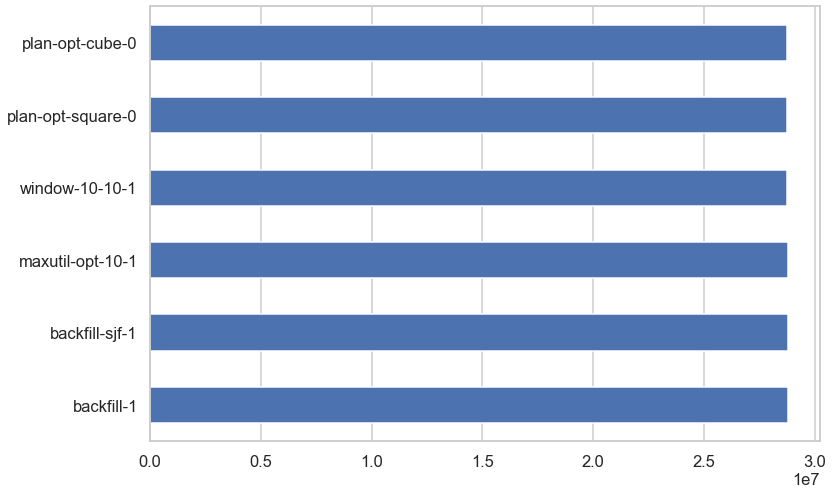

In [20]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

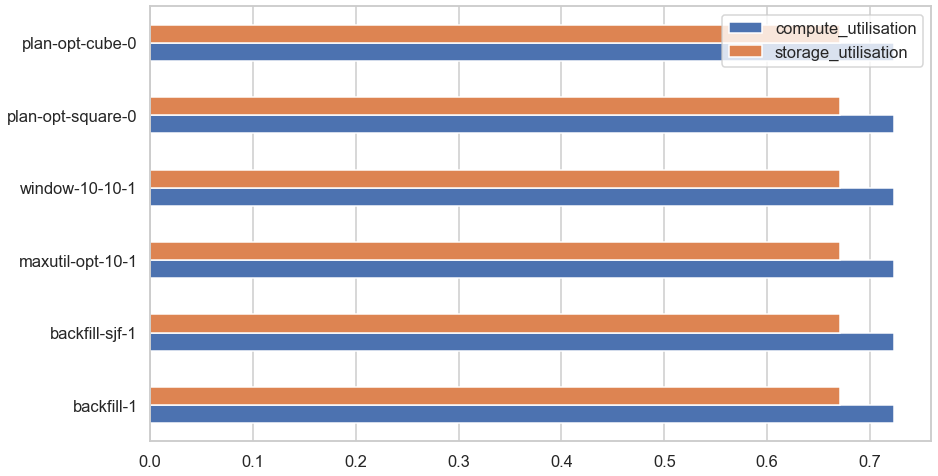

In [21]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [9]:
# rename schedules
new_jobsets = {}
for old_name, new_name in zip(schedule_names, new_names):
    new_jobsets[new_name] = jobsets[old_name]
schedule_names = new_names
jobsets = new_jobsets

In [10]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown,bounded_slowdown
0,backfill-1,0.00000,2488.00020,1.000000,1.000000
1,backfill-1,0.00000,3477.00015,1.000000,1.000000
2,backfill-1,0.00000,29.00020,1.000000,1.000000
3,backfill-1,0.00000,13.00000,1.000000,1.000000
4,backfill-1,0.00000,16.00000,1.000000,1.000000
...,...,...,...,...,...
28462,plan-cube-0,0.00000,8.00000,1.000000,1.000000
28463,plan-cube-0,10160.00410,10640.00445,22.166660,22.166660
28464,plan-cube-0,2739.00365,6325.00385,1.763805,1.763805
28465,plan-cube-0,41494.00040,73553.00055,2.294301,2.294301


In [11]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,backfill-1,backfill-sjf-1,maxutil-1.0-1,window-1,plan-square-0,plan-cube-0
count,28453.000000,28453.000000,28453.000000,28453.000000,2.845300e+04,2.845300e+04
mean,14791.352665,16030.177212,14078.958492,14364.741696,1.105945e+04,1.199261e+04
std,40211.832803,50856.009561,43875.269882,46810.969329,4.610956e+04,4.549880e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,37.001450,9.000550,49.000700,0.000000,3.500045e+01,4.600310e+01
75%,9929.959092,7400.007400,7453.004450,6318.005700,5.003000e+03,5.819000e+03
max,508076.001850,815531.003350,639292.787714,741691.004550,2.490436e+06,1.417185e+06


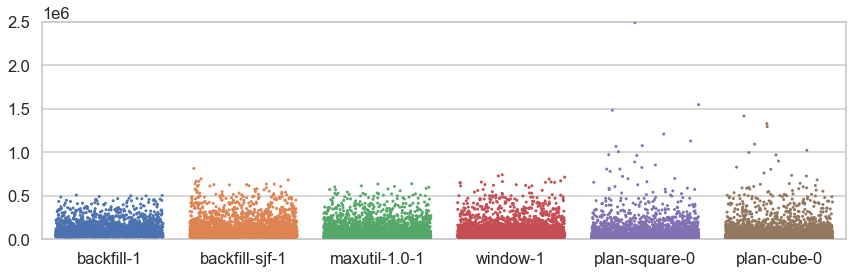

In [14]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylim(top=2.5*10**6)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('../../images/results/best_alloc-only_waiting-time_dist.pdf', bbox_inches='tight')

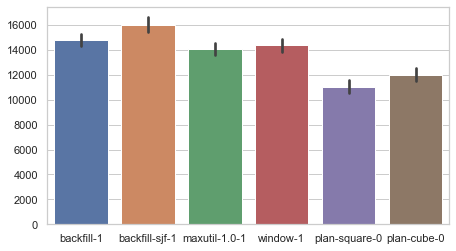

In [15]:
# Mean
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=waiting_times, ax=ax)
fig.savefig('../../images/results/best_alloc-only_waiting-time_mean.pdf', bbox_inches='tight')

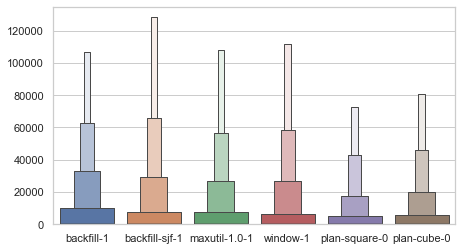

In [16]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('../../images/results/best_alloc-only_waiting-time_boxen.pdf', bbox_inches='tight')

In [17]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,backfill-1,backfill-sjf-1,maxutil-1.0-1,window-1,plan-square-0,plan-cube-0
count,28453.000000,28453.000000,28453.000000,28453.000000,2.845300e+04,2.845300e+04
mean,23648.927217,24887.748654,22936.529950,23222.308958,1.991702e+04,2.085018e+04
std,47445.607468,57692.214071,50658.265844,53523.593578,5.393485e+04,5.373120e+04
min,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00
25%,271.000200,236.000100,274.000650,213.000000,2.350002e+02,2.170000e+02
50%,6278.000400,5046.000000,5628.002050,4749.000200,4.273000e+03,4.461001e+03
75%,25963.224819,22345.000200,21838.000200,21371.001350,1.694200e+04,1.845000e+04
max,622411.957392,815654.003650,667982.871717,751425.004900,2.530291e+06,1.475248e+06


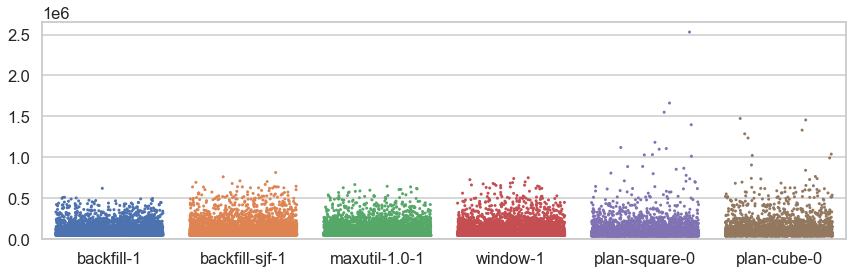

In [18]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('../../images/results/best_alloc-only_turnaround-time_dist.pdf', bbox_inches='tight')

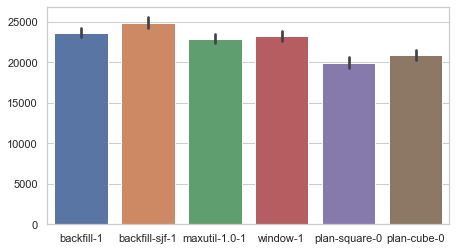

In [19]:
# Mean
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=turnaround_times, ax=ax)
fig.savefig('../../images/results/best_alloc-only_turnaround-time_mean.pdf', bbox_inches='tight')

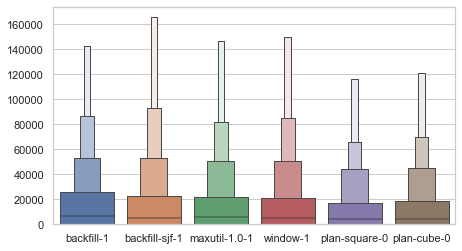

In [20]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('../../images/results/best_alloc-only_turnaround-time_boxen.pdf', bbox_inches='tight')

In [21]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,backfill-1,backfill-sjf-1,maxutil-1.0-1,window-1,plan-square-0,plan-cube-0
count,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,260.313777,258.144750,247.091577,223.343367,165.098150,184.289286
std,2535.926572,3423.560377,2843.020962,2694.631573,2280.712813,2217.781269
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.022040,1.005059,1.021283,1.000000,1.011748,1.017317
75%,6.494006,5.398393,5.644803,4.399000,3.899712,3.923900
max,197917.144035,287202.934185,250555.621457,280245.679556,247174.020161,140605.910818


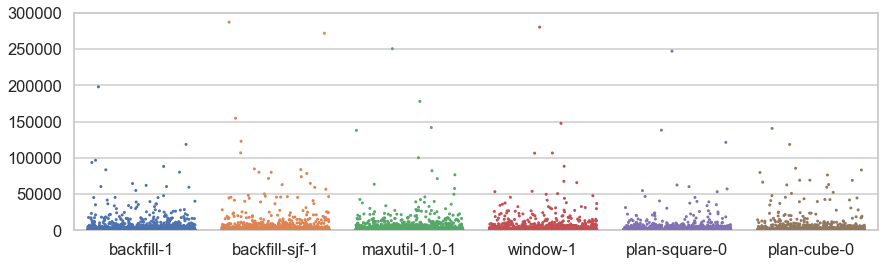

In [22]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylim(top=300000)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('../../images/results/best_alloc-only_slowdown_dist.pdf', bbox_inches='tight')

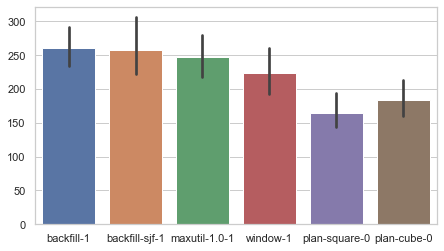

In [23]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=slowdown, ax=ax)
fig.savefig('../../images/results/best_alloc-only_slowdown_mean.pdf', bbox_inches='tight')

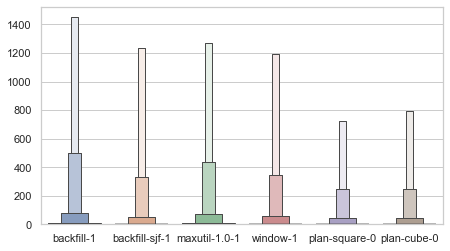

In [24]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('../../images/results/best_alloc-only_slowdown_boxen.pdf', bbox_inches='tight')

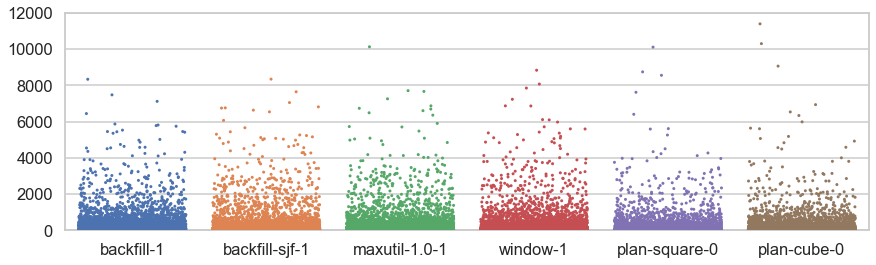

In [25]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'bounded_slowdown']].nlargest(n=4000, columns='bounded_slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='bounded_slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylim(top=12000)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.savefig('../../images/results/best_alloc-only_bounded-slowdown_dist.pdf', bbox_inches='tight')

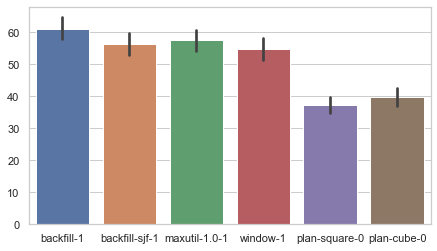

In [26]:
# Mean
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax)
# ax.set_ylim(top=14)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/best_alloc-only_bounded-slowdown_mean.pdf', bbox_inches='tight')

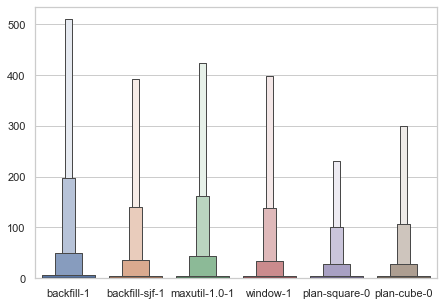

In [27]:
fig, ax = plt.subplots(figsize=(7.2,5))
sns.boxenplot(data=metrics_df, x='schedule', y='bounded_slowdown', k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=80)
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig('../../images/results/best_alloc-only_bounded-slowdown_boxen.pdf', bbox_inches='tight')

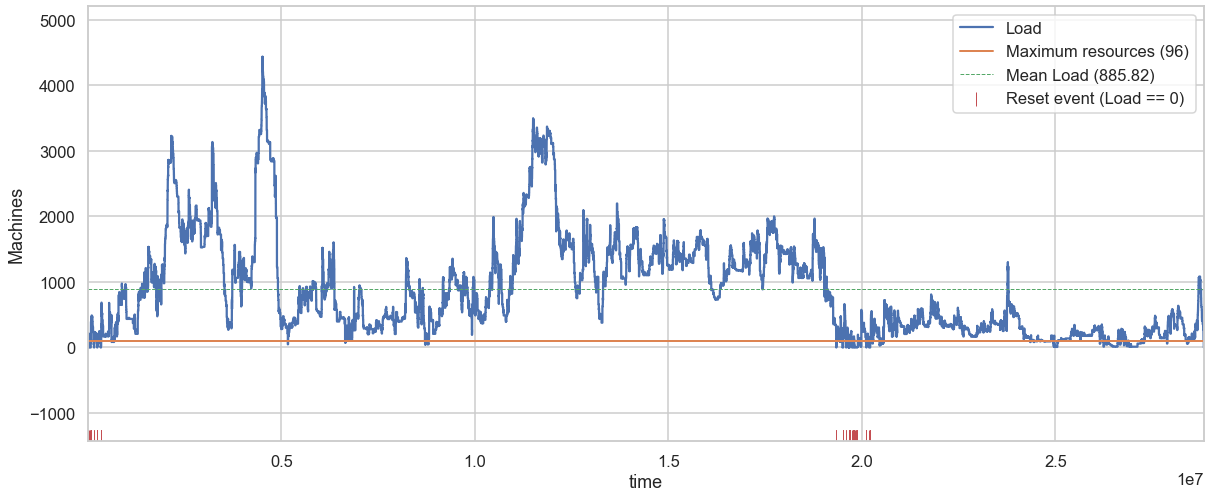

In [382]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)

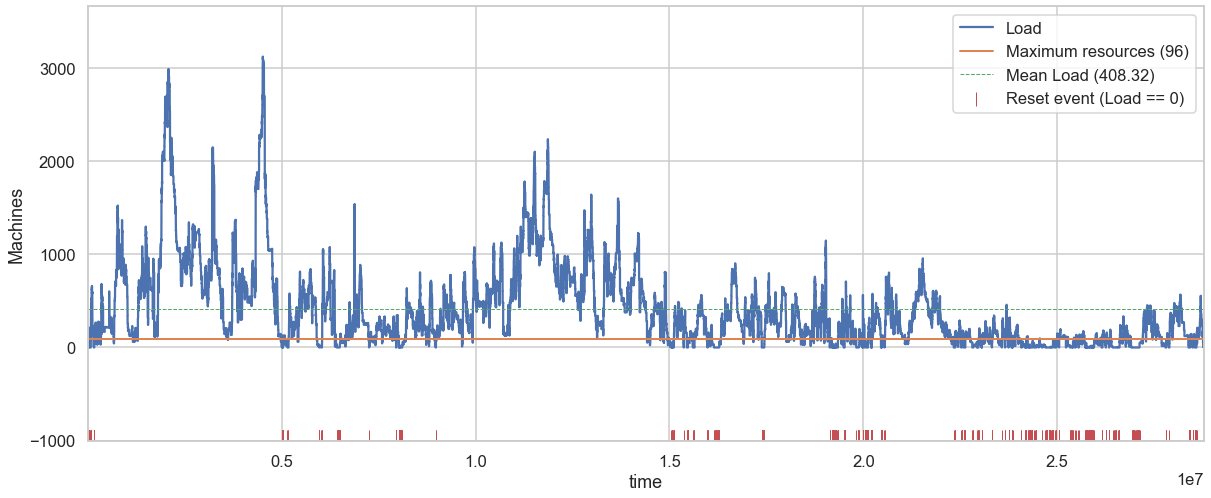

In [383]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

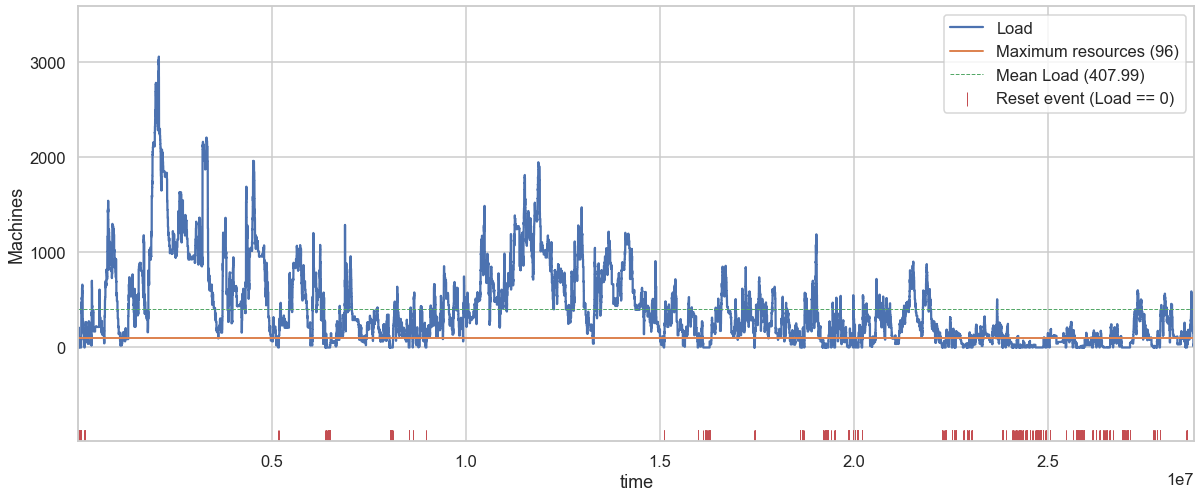

In [384]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['maxutil-1'].queue, nb_resources=96, ax=ax)

In [282]:
def storage_queue(js):
    df = js.df.assign(total_storage=js.df.metadata * js.df.requested_number_of_resources)
    return evalys.metrics.compute_load(df, 'submission_time', 'starting_time', 'total_storage')

def storage_utilisation(js):
    df = js.df.assign(total_storage=js.df.metadata * js.df.requested_number_of_resources)
    return evalys.metrics.compute_load(df, 'starting_time', 'finish_time', 'total_storage')

def remove_immidiate_timepoints(load):
    return load[load.assign(time_diff=df.index).diff().shift(-1)['time_diff'] >= 1]

In [411]:
js = jobsets['maxutil-20-1']

In [412]:
js.utilisation

,load,area
time,,
1.000000e+00,4,688.0000
1.730000e+02,29,13166.0000
6.270000e+02,34,69156.0068
2.661000e+03,9,0.0009
2.661000e+03,26,21241.9961
...,...,...
2.876378e+07,12,187728.0648
2.877942e+07,4,0.0004
2.877942e+07,16,736.0032


In [413]:
js.queue

,load,area
time,,
1.000000e+00,0,0.0000
1.730000e+02,0,0.0000
6.270000e+02,0,0.0000
9.870000e+02,17,28458.0051
2.661000e+03,0,0.0000
...,...,...
2.875892e+07,12,37464.0000
2.876204e+07,12,17976.0000
2.876354e+07,12,2808.0000


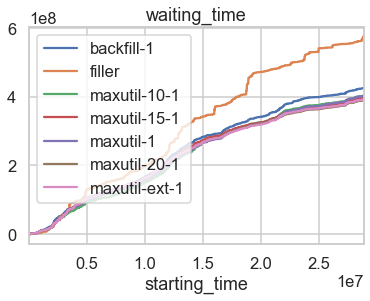

In [415]:
evalys.visu.legacy.plot_series('waiting_time', jobsets)

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/evalys/visu/core.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


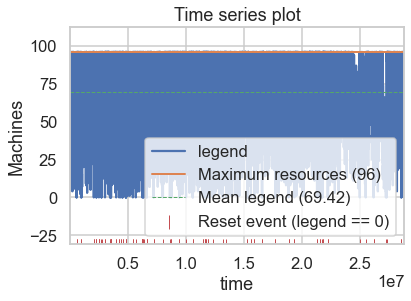

In [70]:
visu.series.plot_series(js, name='utilization', legend_label='legend')

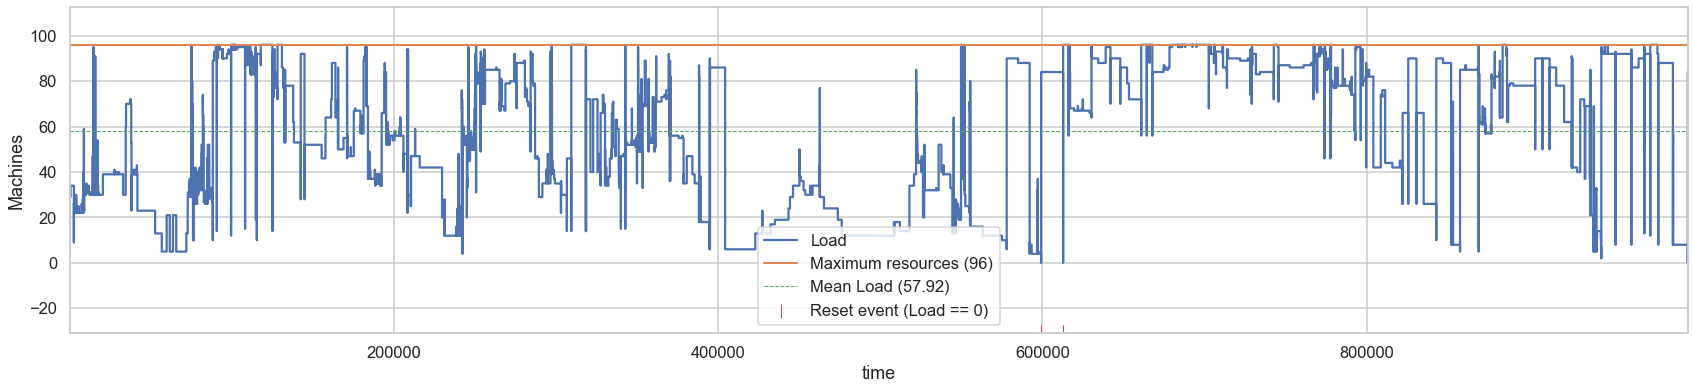

In [428]:
fig, ax = plt.subplots(figsize=(29,6))
df = js.utilisation
df = df[df.index < 0.1 * 1e7]
# df = remove_immidiate_timepoints(df)
evalys.visu.legacy.plot_load(df, 96)

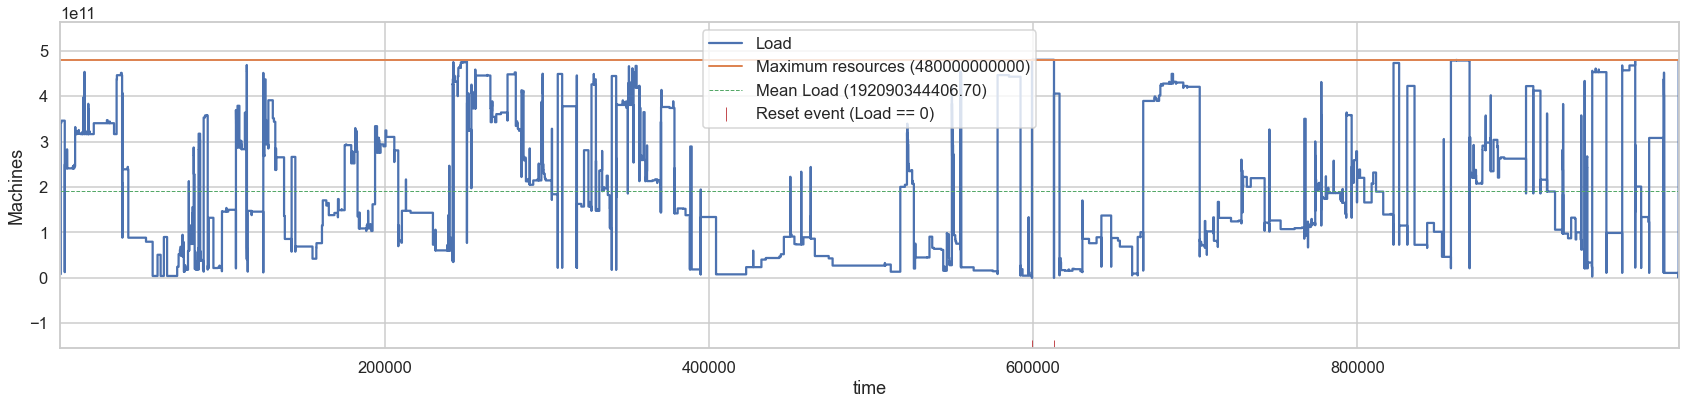

In [417]:
fig, ax = plt.subplots(figsize=(29,6))
df = storage_utilisation(js)
df = df[df.index < 0.1 * 1e7]
evalys.visu.legacy.plot_load(df, 480000000000)

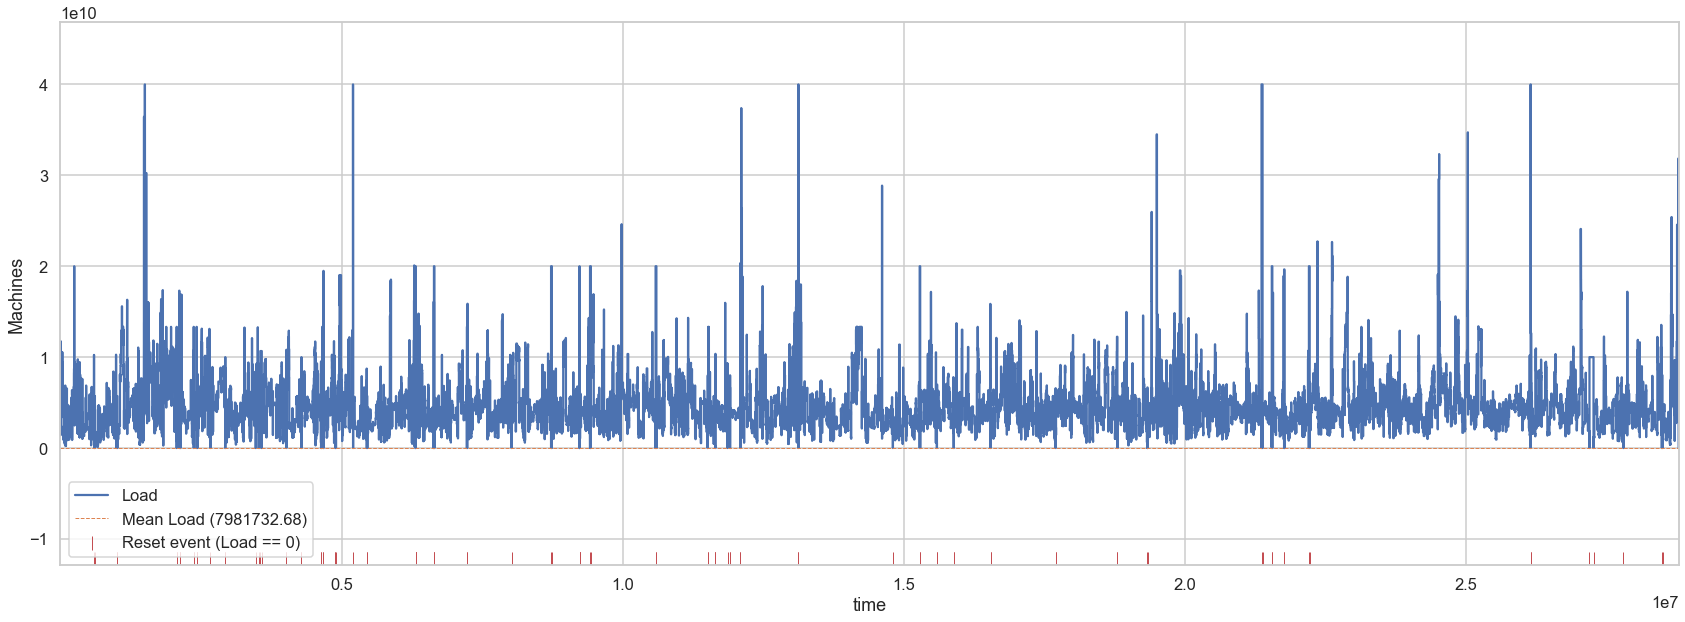

In [420]:
df = storage_utilisation(js) / js.utilisation
df = df.fillna(0)
# df = remove_immidiate_timepoints(df)
# df = df[df.index < 0.5 * 1e7]
fig, ax = plt.subplots(figsize=(29,10))
evalys.visu.legacy.plot_load(df)

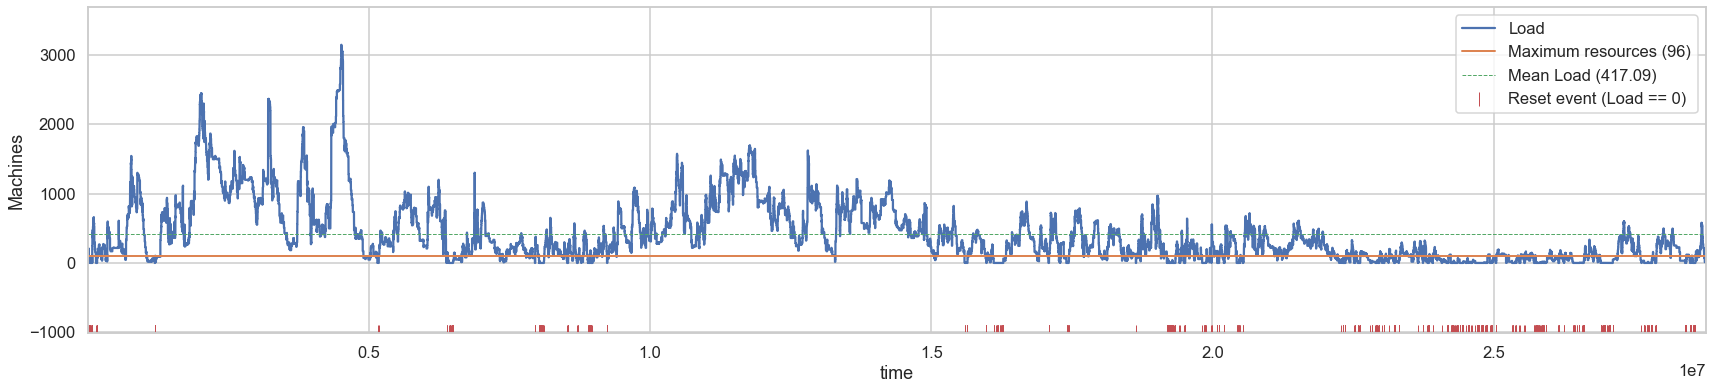

In [421]:
fig, ax = plt.subplots(figsize=(29,6))
df = js.queue
evalys.visu.legacy.plot_load(df, 96)

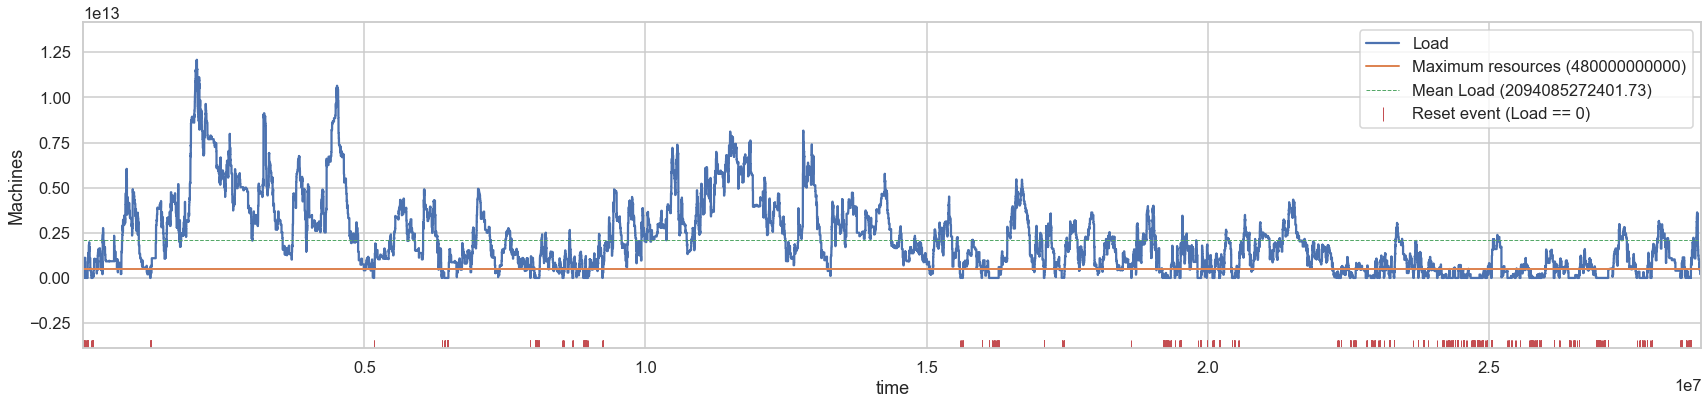

In [422]:
fig, ax = plt.subplots(figsize=(29,6))
df = storage_queue(js)
evalys.visu.legacy.plot_load(df, 480000000000)

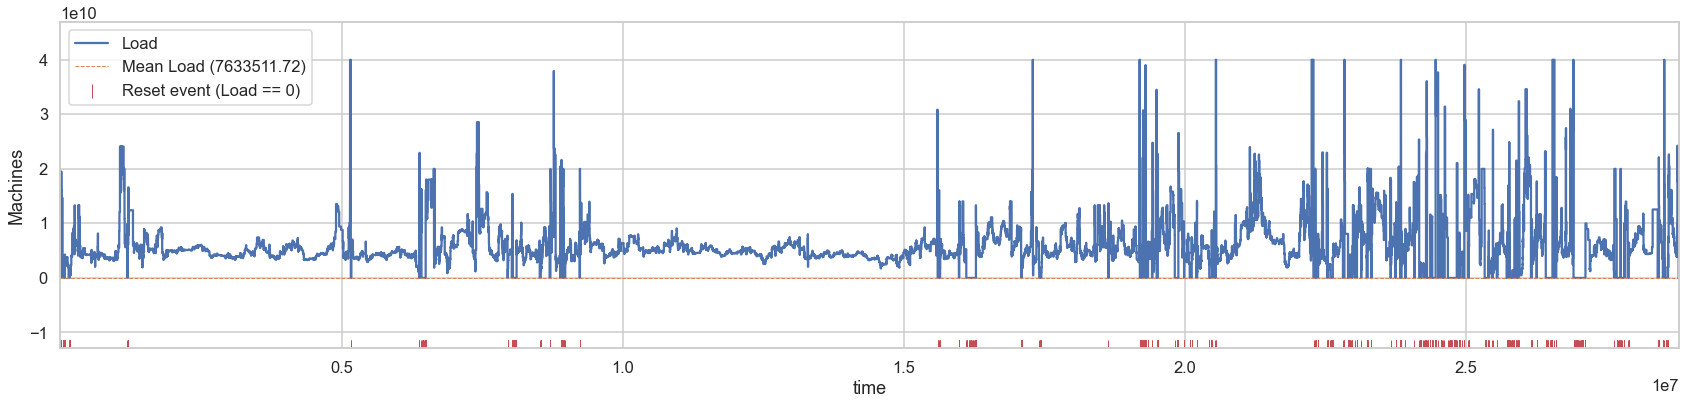

In [429]:
df = storage_queue(js) / js.queue
df = df.fillna(0)
# df = df[df.index < 0.1 * 1e7]
fig, ax = plt.subplots(figsize=(29,6))
evalys.visu.legacy.plot_load(df)

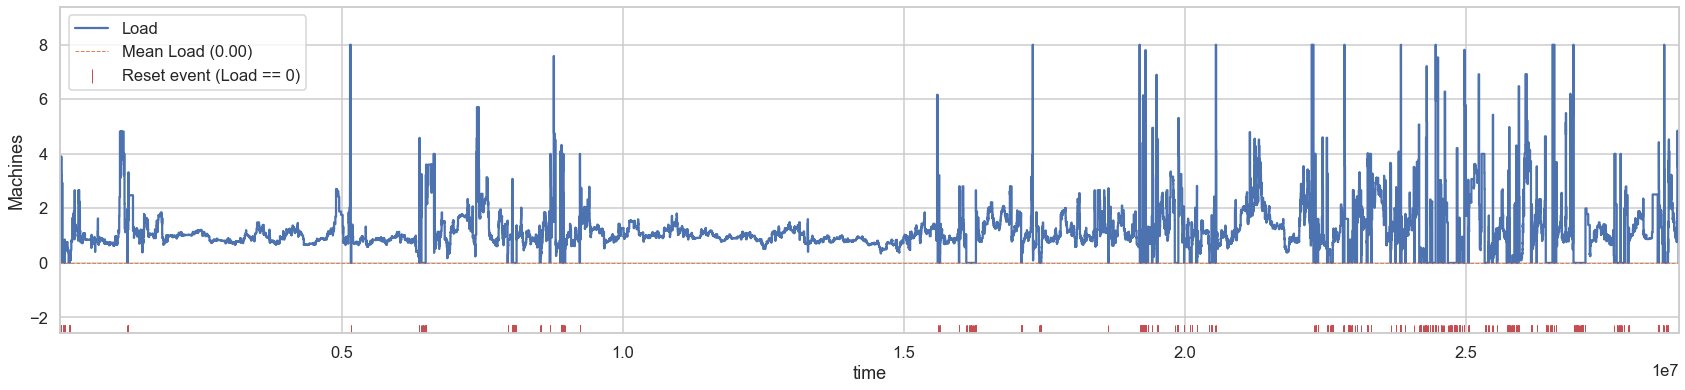

In [424]:
df = df = (storage_queue(js) / 480000000000) / (js.queue / 96)  # Queue ratio
df = df.fillna(0)
# df = df[df.index < 0.1 * 1e7]
fig, ax = plt.subplots(figsize=(29,6))
evalys.visu.legacy.plot_load(df)

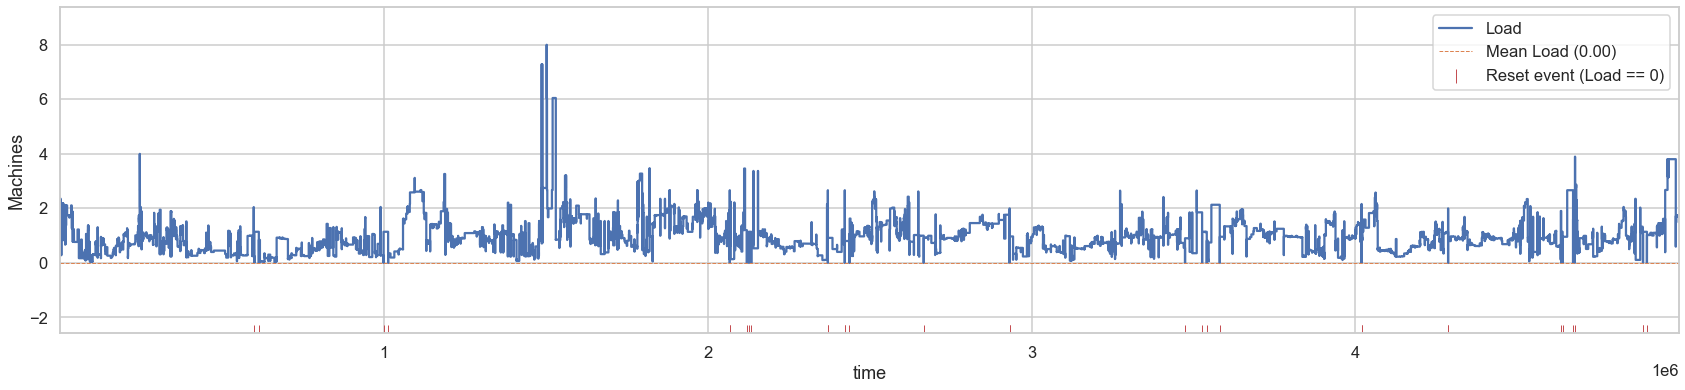

In [425]:
# When point is at 1.0 then storage and compute utilisation is balanced. Below 1.0 compute dominates.
df = (storage_utilisation(js) / 480000000000) / (js.utilisation / 96)  # Utilisation ratio
df = df.fillna(0)
df = df[df.index < 0.5 * 1e7]
fig, ax = plt.subplots(figsize=(29,6))
evalys.visu.legacy.plot_load(df)